[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Stef0916/chemoinformatics-bioinformatics/blob/main/cheminformatics-workflow/notebooks/8-Chemical_smilarity.ipynb)

# Chemical Similarity

The chemical similarity concept is crucial for Structure-Activity Relationship (SAR) analysis. This is based on a postulate that similar compounds have similar activity. This seems easy enough. However, a detailed look at a series of compounds shows that considering a group of compounds as similar/dissimilar can be quite dependent on the activity in question.

The similarity issue, depending on what one needs to compare, can be overcome by using appropriate molecular descriptors. However, many bioactivities need a better mechanistic interpretation, thus making focused descriptor selection impossible.

## Similarity metrics:

SAR analysis needs to quantify the similarity between compounds of the dataset. This allows, for example, a range of compounds by similarity reference.

There are many similarity metrics. One of the simplest ones would be the number of atoms or bonds within the **maximum common substructure (MCS)**. Here are alternatives metric that use descriptor space:

1. **Tamimoto Similarity:** This is the version of the Jaccard similarity index, where the similarity between sets is determined by comparing the shared elements vs all elements in two sets. Sets are compounds (A, B), and elements are respective descriptor types (i). Tanimoto similarity ranges from 0 (no similar elements) to 1 (identical compounds)
2. **Euclidean distance:** This is applied to the nth-dimension descriptor space. It ranges from 0 (identical compounds) to infinity (the more descriptors there are in the space, the higher this number can potentially get for completely different compounds).

The main difference between Tanimoto and Euclidean is that Tanimoto has a strictly determined range, whereas Euclidean distances allow for a more detailed differentiation. Ts, however, does not suffer from descriptor types having contrasting orders of magnitude.


## Content

1. [Load Libraries](#1)
2. [Load Dataset](#2)
3. [Visualize the Molecules](#3)
4. [Using MACCS Fingerprints](#4)
    - 4.1 [Calculate the MACCS fingerprints](#5)
    - 4.2 [Similarity Matrix Pairwise](#6)
        - 4.2.1 [Alternative 1 with SciKit-Learn](#7)
        - 4.2.2 [Alternative 2 with RDKit](#8)
        - 4.2.3 [Alternative 2 manual calculation](#9)
    - 4.3 [Euclidean and Tanimoto to find th most similar compounds](#10)
        - 4.3.1 [Compare all the alternatives](#11)


## 1. Import Libraries<a name = 1></a>

In [1]:
!pip install rdkit

In [2]:
!pip install mols2grid

In [3]:
import pandas as pd
import numpy as np
import copy

#--------------------------------------------------------------

from rdkit import Chem, DataStructs
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
from rdkit.Chem import Draw, PandasTools, MACCSkeys
from rdkit.Chem import rdDepictor
from rdkit.ML.Descriptors import MoleculeDescriptors
IPythonConsole.ipython_useSVG = True
rdDepictor.SetPreferCoordGen(True)
import mols2grid

#--------------------------------------------------------------

import sklearn.metrics

import rdkit
rdkit.__version__

'2023.09.1'

## 2. Load Datasets<a name = 2></a>

In [4]:
data = PandasTools.LoadSDF('AID_1259247_sanitized.sdf', molColName='Molecule')

In [5]:
data.head()

,PUBCHEM_SMILES,PUBCHEM_ACTIVITY_OUTCOME,Antagonist Activity,Viability Activity,Antagonist Efficacy (%),ID,Molecule
0,CN1C2=NC=NC3=C2C(=CN3[C@H]4[C@@H]([C@@H]([C@H]...,Active,active antagonist,inactive,-37.5702,,<rdkit.Chem.rdchem.Mol object at 0x7fdf48a2d700>
1,C[C@]12CC[C@H]3C(=CCC4=C3C=CC(=C4)O)[C@@H]1CCC2=O,Active,active antagonist,inactive,-37.9252,,<rdkit.Chem.rdchem.Mol object at 0x7fdf05f3d770>
2,C1=NC2=C(N=C(N=C2N1[C@H]3[C@H]([C@@H]([C@H](O3...,Active,active antagonist,inactive,-35.847,,<rdkit.Chem.rdchem.Mol object at 0x7fdf05f3d850>
3,CCOC1=CC2=C(C3=C(C=C(C=C3)N)N=C2C=C1)N.CC(C(=O...,Active,active antagonist,inactive,-35.5194,,<rdkit.Chem.rdchem.Mol object at 0x7fdf05f3d620>
4,CCCCOC(=O)C1=CC=CC=C1C(=O)OCC2=CC=CC=C2,Active,active antagonist,inactive,-39.4007,,<rdkit.Chem.rdchem.Mol object at 0x7fdf05f3da10>


In [6]:
len(data)

5134

In [7]:
data['Antagonist Efficacy (%)'] = data['Antagonist Efficacy (%)'].astype('float64')

## 3. Visualize the Molecules<a name = 3></a>

In [8]:
mols2grid.display(data, mol_col = 'Molecule', subset = ['Antagonist Efficacy (%)', 'PUBCHEM_ACTIVITY_OUTCOME'],
                  transform = {"Antagonist Efficacy (%)": lambda x: f"{x:.2f}"})

MolGridWidget()

## 4. Using MACCS Fingerprints<a name = 4></a>

### 4.1 Calculate the MACCS fingerprints<a name = 5></a>

In [9]:
def generate_maccs_fps(data):
    """Generate MACCS fingerprints for a list of SMILES strings.

    Parameters:
    - data (list of str): List of RDKit objects strings representing molecules.

    Returns:
    - numpy.ndarray: An array where each row corresponds to the MACCS fingerprint of a molecule.
                     Each fingerprint is a fixed-length (typically 166-bits) binary array."""

    MACCS_fps = []
    for mol in data:
        fp = MACCSkeys.GenMACCSKeys(mol)
        MACCS_fps.append(fp)
    return np.array(MACCS_fps)

In [10]:
maccs_fps = generate_maccs_fps(data['Molecule'])
maccs_fps

array([[0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0]])

In [11]:
maccs_fps_df = pd.DataFrame(maccs_fps,columns=['Col_{}'.format(i) for i in range(maccs_fps.shape[1])])

In [12]:
maccs_fps_df

,Col_0,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,...,Col_157,Col_158,Col_159,Col_160,Col_161,Col_162,Col_163,Col_164,Col_165,Col_166
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5129,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5130,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,0,0,1,0,0
5131,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5132,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0


### 4.2 Similarity Matrix Pairwise<a name = 6></a>
---

#### **Alternative 1 with Scikit-learn**<a name = 7></a>

In [13]:
Dist_mat = sklearn.metrics.pairwise.euclidean_distances(maccs_fps_df)
Tanimoto_matrix = sklearn.metrics.pairwise_distances(np.array(maccs_fps_df), metric='jaccard') #Tanimoto distance is 1-Tanimoto similarity

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


For the Jaccard calculation it is expected to have `binary` data. We need to transform the data into boolean.

In [14]:
maccs_fps_df.iloc[0,0:20]

Col_0     0
Col_1     0
Col_2     0
Col_3     0
Col_4     0
Col_5     0
Col_6     0
Col_7     0
Col_8     0
Col_9     0
Col_10    0
Col_11    0
Col_12    0
Col_13    0
Col_14    0
Col_15    0
Col_16    0
Col_17    0
Col_18    0
Col_19    0
Name: 0, dtype: int64

In [15]:
# Convert the array into boolean
finger_array = np.array(maccs_fps_df).astype(bool)

In [16]:
finger_array

array([[False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True,  True, False],
       ...,
       [False, False, False, ..., False,  True, False],
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True,  True, False]])

In [17]:
Tanimoto_matrix = sklearn.metrics.pairwise_distances(finger_array, metric='jaccard')

In [18]:
Tanimoto_matrix.round(2)

array([[0.  , 0.78, 0.25, ..., 0.93, 0.61, 0.67],
       [0.78, 0.  , 0.8 , ..., 0.86, 0.75, 0.76],
       [0.25, 0.8 , 0.  , ..., 0.93, 0.7 , 0.74],
       ...,
       [0.93, 0.86, 0.93, ..., 0.  , 0.88, 0.88],
       [0.61, 0.75, 0.7 , ..., 0.88, 0.  , 0.15],
       [0.67, 0.76, 0.74, ..., 0.88, 0.15, 0.  ]])

In [19]:
np.savetxt('tanimoto_sklearn.txt', Tanimoto_matrix)

In [20]:
Dist_mat.round(2)

array([[0.  , 7.87, 4.24, ..., 8.25, 7.  , 7.35],
       [7.87, 0.  , 7.75, ..., 5.66, 6.71, 6.63],
       [4.24, 7.75, 0.  , ..., 7.87, 7.55, 7.75],
       ...,
       [8.25, 5.66, 7.87, ..., 0.  , 6.71, 6.48],
       [7.  , 6.71, 7.55, ..., 6.71, 0.  , 2.65],
       [7.35, 6.63, 7.75, ..., 6.48, 2.65, 0.  ]])

In [21]:
np.savetxt('euclidean_sklearn.txt', Dist_mat)

#### **Alternative 2 with RDKit**<a name = 8></a>

`DataStructs.FingerprintSimilarity` expects `ExplicitBitVect`. I have to transform the fingerprints with the help of `DataStructs.ExplicitBitVect`

In [22]:
def numpy_array_to_explicit_bit_vect(arr):
    bit_vect = DataStructs.ExplicitBitVect(len(arr))
    for i, bit in enumerate(arr):
        if bit:
            bit_vect.SetBit(i)
    return bit_vect

In [23]:
explicit_bit_vects = [numpy_array_to_explicit_bit_vect(fp) for fp in maccs_fps]
explicit_bit_vects[:10]

In [24]:
Tanimoto_bitmatrix = np.full((len(data), len(data)), -1, dtype='float64') #-1 needs to be changed afterwards

for i in range(len(data)):
    for j in range(i+1, len(data)):  # start from i+1 to avoid duplicate calculations and self-comparisons
        Tanimoto_bitmatrix[i, j] = DataStructs.FingerprintSimilarity(explicit_bit_vects[i], explicit_bit_vects[j])
        Tanimoto_bitmatrix[j, i] = Tanimoto_bitmatrix[i, j]  # since the matrix is symmetric

In [25]:
Tanimoto_bitmatrix.round(2)

array([[-1.  ,  0.22,  0.75, ...,  0.07,  0.39,  0.33],
       [ 0.22, -1.  ,  0.2 , ...,  0.14,  0.25,  0.24],
       [ 0.75,  0.2 , -1.  , ...,  0.07,  0.3 ,  0.26],
       ...,
       [ 0.07,  0.14,  0.07, ..., -1.  ,  0.12,  0.12],
       [ 0.39,  0.25,  0.3 , ...,  0.12, -1.  ,  0.85],
       [ 0.33,  0.24,  0.26, ...,  0.12,  0.85, -1.  ]])

After the computation, Tanimoto_bitmatrix will contain the Tanimoto similarity scores for each pair of molecules. The diagonal elements, which represent the similarity of a molecule with itself, will remain -1. To set them to 1 (since a molecule is always identical to itself).

In [26]:
# Change -1 to 1
Tanimoto_bitmatrix[Tanimoto_bitmatrix == -1] = 1

In [27]:
Tanimoto_bitmatrix.round(2)

array([[1.  , 0.22, 0.75, ..., 0.07, 0.39, 0.33],
       [0.22, 1.  , 0.2 , ..., 0.14, 0.25, 0.24],
       [0.75, 0.2 , 1.  , ..., 0.07, 0.3 , 0.26],
       ...,
       [0.07, 0.14, 0.07, ..., 1.  , 0.12, 0.12],
       [0.39, 0.25, 0.3 , ..., 0.12, 1.  , 0.85],
       [0.33, 0.24, 0.26, ..., 0.12, 0.85, 1.  ]])

#### **Alternative 3 manual calculation**<a name = 9></a>

The Tanimoto similarity between two vectors \( A \) and \( B \) is defined as:

$$
\text{Tanimoto}(A, B) = \frac{\sum \min(A_i, B_i)}{\sum \max(A_i, B_i)}
$$


In [28]:
# # Get the Tanimoto for everything
# num_molecules = len(data)
# Tanimoto_bitmatrix_all = np.full((num_molecules, num_molecules), -1, dtype='float64')

# for i in range(num_molecules):
#     for j in range(i+1, num_molecules):  # start from i+1 to avoid duplicate calculations and self-comparisons
#         nomin = np.sum(np.minimum(maccs_fps_df.iloc[i,:], maccs_fps_df.iloc[j,:]))
#         denom = np.sum(np.maximum(maccs_fps_df.iloc[i,:], maccs_fps_df.iloc[j,:]))
#         Tanimoto_bitmatrix_all[i, j] = nomin / denom if denom != 0 else 0
#         Tanimoto_bitmatrix_all[j, i] = Tanimoto_bitmatrix_all[i, j]  # since the matrix is symmetric

# # Set diagonal to 1
# np.fill_diagonal(Tanimoto_bitmatrix_all, 1)

In [29]:
# Tanimoto_bitmatrix_all.round(2)

## 5. Use Euclidean and Tanimoto to find the most similar compounds<a name = 10></a>

In [30]:
data.loc[data['PUBCHEM_ACTIVITY_OUTCOME'] == 'Active']

,PUBCHEM_SMILES,PUBCHEM_ACTIVITY_OUTCOME,Antagonist Activity,Viability Activity,Antagonist Efficacy (%),ID,Molecule
0,CN1C2=NC=NC3=C2C(=CN3[C@H]4[C@@H]([C@@H]([C@H]...,Active,active antagonist,inactive,-37.5702,,<rdkit.Chem.rdchem.Mol object at 0x7fdf48a2d700>
1,C[C@]12CC[C@H]3C(=CCC4=C3C=CC(=C4)O)[C@@H]1CCC2=O,Active,active antagonist,inactive,-37.9252,,<rdkit.Chem.rdchem.Mol object at 0x7fdf05f3d770>
2,C1=NC2=C(N=C(N=C2N1[C@H]3[C@H]([C@@H]([C@H](O3...,Active,active antagonist,inactive,-35.8470,,<rdkit.Chem.rdchem.Mol object at 0x7fdf05f3d850>
3,CCOC1=CC2=C(C3=C(C=C(C=C3)N)N=C2C=C1)N.CC(C(=O...,Active,active antagonist,inactive,-35.5194,,<rdkit.Chem.rdchem.Mol object at 0x7fdf05f3d620>
4,CCCCOC(=O)C1=CC=CC=C1C(=O)OCC2=CC=CC=C2,Active,active antagonist,inactive,-39.4007,,<rdkit.Chem.rdchem.Mol object at 0x7fdf05f3da10>
5,C1CC1C2=CC=CC=C2OCC3=NCCN3,Active,active antagonist,inactive,-38.8571,,<rdkit.Chem.rdchem.Mol object at 0x7fdf05f3daf0>
6,C1=CC=C2C=C3C4=CC=CC=C4C5=CC=CC=C5C3=CC2=C1,Active,active antagonist,inactive,-38.3391,,<rdkit.Chem.rdchem.Mol object at 0x7fdf05f3db60>
7,C1=CC=C2C(=C1)C(=O)C(C2=O)C3=NC4=CC=CC=C4C(=C3...,Active,active antagonist,inactive,-36.3573,,<rdkit.Chem.rdchem.Mol object at 0x7fdf05f3dbd0>
8,CCCCNS(=O)(=O)C1=CC=CC=C1,Active,active antagonist,inactive,-39.8567,,<rdkit.Chem.rdchem.Mol object at 0x7fdf05f3dc40>
9,C1=CC=C(C=C1)C(C2=CC=CC=C2)(C3=CC=CC=C3)Cl,Active,active antagonist,inactive,-39.0402,,<rdkit.Chem.rdchem.Mol object at 0x7fdf05f3dd20>


### 4.1 Compare all the alternatives<a name = 11></a>

In [31]:
# Get results for the reference
np.set_printoptions(precision = 2, suppress=True) #avoid scientific notations
reference_dist = copy.deepcopy(Dist_mat[2,:]) #min from sklear
reference_Ts = copy.deepcopy(Tanimoto_matrix[2,:]) #min from sklear
reference_Ts_bit = copy.deepcopy(Tanimoto_bitmatrix[2,:]) #max from RDKit
# reference_Ts_all = copy.deepcopy(Tanimoto_bitmatrix_all[0,:]) #max from my code

In [32]:
# Find the most similar compound
np.where(reference_dist == min(reference_dist[reference_dist !=0]))

(array([1864]),)

0.0


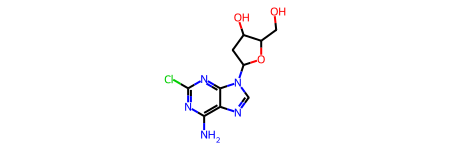

In [33]:
print(data['Antagonist Efficacy (%)'][1864])
data['Molecule'][1864]

-35.847


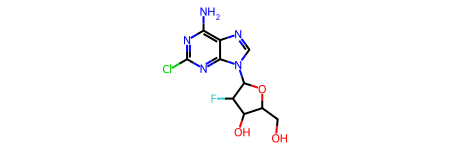

In [34]:
print(data['Antagonist Efficacy (%)'][2])
data['Molecule'][2]

In [35]:
# Compare to the jaccard with scikit-learn
np.where(reference_Ts == min(reference_Ts[reference_Ts !=0]))

(array([1864]),)

In [36]:
# Compare to the matrix with RDKit
np.where(reference_Ts_bit == max(reference_Ts_bit[reference_Ts_bit !=1]))

(array([1864]),)

In [37]:
# # Compare to the matrix made by hand
# np.where(reference_Ts_all == max(reference_Ts_all[reference_Ts_all !=1]))